In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')

Using TensorFlow backend.


# Load Dataset

In [2]:
xr_train = np.load('dataset/xr_train.npy').astype(np.float32)
yr_train = np.load('dataset/yr_train.npy').astype(np.float32)
xr_val = np.load('dataset/xr_val.npy').astype(np.float32)
yr_val = np.load('dataset/yr_val.npy').astype(np.float32)
xl_train = np.load('dataset/xl_train.npy').astype(np.float32)
yl_train = np.load('dataset/yl_train.npy').astype(np.float32)
xl_val = np.load('dataset/xl_val.npy').astype(np.float32)
yl_val = np.load('dataset/yl_val.npy').astype(np.float32)

print(xr_train.shape, yr_train.shape)
print(xr_val.shape, yr_val.shape)
print(xl_train.shape, yl_train.shape)
print(xl_val.shape, yl_val.shape)

(18, 24, 24, 1) (18, 1)
(5, 24, 24, 1) (5, 1)
(18, 24, 24, 1) (18, 1)
(5, 24, 24, 1) (5, 1)


In [3]:
IMG_HEIGHT = 24
IMG_WIDTH = 24

# Preview

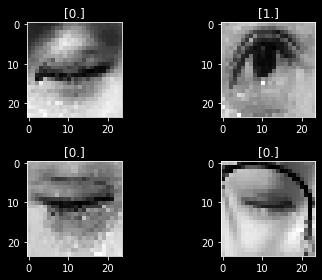

In [4]:
plt.subplot(2, 2, 1)
plt.title(str(yr_train[0]))
plt.imshow(xr_train[0].reshape((IMG_HEIGHT, IMG_WIDTH)), cmap='gray')
plt.subplot(2, 2, 2)
plt.title(str(yr_val[4]))
plt.imshow(xr_val[4].reshape((IMG_HEIGHT, IMG_WIDTH)), cmap='gray')
plt.subplot(2, 2, 3)
plt.title(str(yl_train[0]))
plt.imshow(xl_train[0].reshape((IMG_HEIGHT, IMG_WIDTH)), cmap='gray')
plt.subplot(2, 2, 4)
plt.title(str(yl_val[4]))
plt.imshow(xl_val[4].reshape((IMG_HEIGHT, IMG_WIDTH)), cmap='gray')
plt.tight_layout()

# Data Augmentation

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

r_train_generator = train_datagen.flow(
    x=xr_train, y=yr_train,
    batch_size=32,
    shuffle=True
)

l_train_generator = train_datagen.flow(
    x=xl_train, y=yl_train,
    batch_size=32,
    shuffle=True
)

r_val_generator = val_datagen.flow(
    x=xr_val, y=yr_val,
    batch_size=32,
    shuffle=False
)

l_val_generator = val_datagen.flow(
    x=xl_val, y=yl_val,
    batch_size=32,
    shuffle=False
)

# Build Model

In [10]:
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 24, 24, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 128)         0   

# Train

In [11]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    r_train_generator, epochs=50, validation_data=r_val_generator,
    callbacks=[
        ModelCheckpoint('models/%sr.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

model.fit_generator(
    l_train_generator, epochs=50, validation_data=l_val_generator,
    callbacks=[
        ModelCheckpoint('models/%sl.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

Epoch 1/50
1/1 [==============================] - 0s 427ms/step - loss: 0.6937 - acc: 0.5000 - val_loss: 0.6857 - val_acc: 0.6000

Epoch 00001: val_acc improved from -inf to 0.60000, saving model to models/2020_05_10_20_53_08r.h5
Epoch 2/50
1/1 [==============================] - 0s 20ms/step - loss: 0.6895 - acc: 0.5000 - val_loss: 0.7054 - val_acc: 0.4000

Epoch 00002: val_acc did not improve from 0.60000
Epoch 3/50
1/1 [==============================] - 0s 94ms/step - loss: 0.6818 - acc: 0.6667 - val_loss: 0.7334 - val_acc: 0.4000

Epoch 00003: val_acc did not improve from 0.60000
Epoch 4/50
1/1 [==============================] - 0s 97ms/step - loss: 0.6825 - acc: 0.6667 - val_loss: 0.7136 - val_acc: 0.2000

Epoch 00004: val_acc did not improve from 0.60000
Epoch 5/50
1/1 [==============================] - 0s 101ms/step - loss: 0.6629 - acc: 0.6667 - val_loss: 0.7167 - val_acc: 0.4000

Epoch 00005: val_acc did not improve from 0.60000
Epoch 6/50
1/1 [==============================] -

1/1 [==============================] - 0s 86ms/step - loss: 0.6089 - acc: 0.7778 - val_loss: 0.7765 - val_acc: 0.4000

Epoch 00045: val_acc did not improve from 0.60000
Epoch 46/50
1/1 [==============================] - 0s 86ms/step - loss: 0.5818 - acc: 0.6667 - val_loss: 0.7770 - val_acc: 0.4000

Epoch 00046: val_acc did not improve from 0.60000
Epoch 47/50
1/1 [==============================] - 0s 87ms/step - loss: 0.6132 - acc: 0.6667 - val_loss: 0.7772 - val_acc: 0.4000

Epoch 00047: val_acc did not improve from 0.60000
Epoch 48/50
1/1 [==============================] - 0s 86ms/step - loss: 0.5621 - acc: 0.8889 - val_loss: 0.7775 - val_acc: 0.4000

Epoch 00048: val_acc did not improve from 0.60000
Epoch 49/50
1/1 [==============================] - 0s 100ms/step - loss: 0.6046 - acc: 0.7778 - val_loss: 0.7779 - val_acc: 0.4000

Epoch 00049: val_acc did not improve from 0.60000
Epoch 50/50
1/1 [==============================] - 0s 74ms/step - loss: 0.6552 - acc: 0.5000 - val_loss: 0

1/1 [==============================] - 0s 32ms/step - loss: 0.6531 - acc: 0.5000 - val_loss: 0.6376 - val_acc: 0.6000

Epoch 00040: val_acc did not improve from 0.80000
Epoch 41/50
1/1 [==============================] - 0s 32ms/step - loss: 0.6478 - acc: 0.6111 - val_loss: 0.6369 - val_acc: 0.8000

Epoch 00041: val_acc did not improve from 0.80000
Epoch 42/50
1/1 [==============================] - 0s 31ms/step - loss: 0.6554 - acc: 0.5556 - val_loss: 0.6362 - val_acc: 0.8000

Epoch 00042: val_acc did not improve from 0.80000
Epoch 43/50
1/1 [==============================] - 0s 33ms/step - loss: 0.6494 - acc: 0.4444 - val_loss: 0.6357 - val_acc: 0.8000

Epoch 00043: val_acc did not improve from 0.80000
Epoch 44/50
1/1 [==============================] - 0s 34ms/step - loss: 0.6623 - acc: 0.5000 - val_loss: 0.6350 - val_acc: 0.8000

Epoch 00044: val_acc did not improve from 0.80000
Epoch 45/50
1/1 [==============================] - 0s 32ms/step - loss: 0.6822 - acc: 0.5556 - val_loss: 0.

# Confusion Matrix

test acc: 0.6


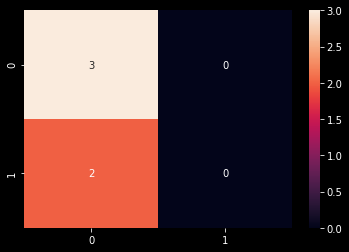

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('models/%sr.h5' % (start_time))

yr_pred = model.predict(xr_val/255.)
yr_pred_logical = (yr_pred > 0.7).astype(np.int)

print ('test acc: %s' % accuracy_score(yr_val, yr_pred_logical))
cm = confusion_matrix(yr_val, yr_pred_logical)
sns.heatmap(cm, annot=True)

# Distribution of Prediction

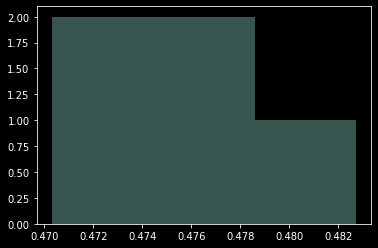

In [15]:
ax = sns.distplot(yr_pred, kde=False)